In [1]:
# K-Means Clustering and also Gaussian Mixture Models (GMM) Clustering
# Goal: Group athletes into distinct training profiles based on their performance metrics.

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
scaled_data = pd.read_csv('../data/scaled_clustering_data.csv', index_col=0)
athlete_profiles = pd.read_csv('../data/athlete_profiles.csv')

print(f"Loaded {len(scaled_data)} athletes with {scaled_data.shape[1]} features")
print(f"\nFeatures: {list(scaled_data.columns)}")

Loaded 115 athletes with 6 features

Features: ['avg_weekly_mileage', 'avg_pace_km', 'avg_training_days', 'avg_fatigue_index', 'avg_consistency_index', 'avg_recovery_ratio']


In [2]:
# using elbow method to find optimal number of clusters for K-Means
# first testing with k=2 ro k=10 and plot the inertia

'''
Intertia = Σ (distance from point to its cluster center)²
    - Measures how tightly the data points in a cluster are grouped around the centroid 
    - Lower inertia means better clustering
    - Usually always decreases with increasing k (more clusters = smaller groups)

Silhouette Score: s(i) = (b(i) - a(i)) / max(a(i), b(i))
    - measures how well each point fits in its cluster compared to other clusters
    - range is -1 to 1
    - higher is better (closer to 1 means well clustered, around 0 means overlapping clusters, negative means misclassified)

Davies-Bouldin Index: DB = (1/k) x Σ max(R_ij)
    - measures average similarity between each cluster and its most similar one
    - lower is better (<1 is good, 1 < 2 is acceptable, >2 is poor)

'''

# K-Means Clustering - Elbow Method
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

print('Testing K-Means clustering for k=2 to k=10...\n')

# looping through the range of k values
for k in K_range:

    # Initialize KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)

    # calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))

    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")


print("\nElbow method analysis complete!")

Testing K-Means clustering for k=2 to k=10...

K=2: Inertia=396.52, Silhouette=0.501, Davies-Bouldin=0.766
K=3: Inertia=259.30, Silhouette=0.341, Davies-Bouldin=0.980
K=4: Inertia=213.31, Silhouette=0.284, Davies-Bouldin=1.091
K=5: Inertia=172.76, Silhouette=0.298, Davies-Bouldin=0.978
K=6: Inertia=146.00, Silhouette=0.285, Davies-Bouldin=0.971
K=7: Inertia=131.82, Silhouette=0.293, Davies-Bouldin=0.989
K=8: Inertia=118.23, Silhouette=0.284, Davies-Bouldin=1.026
K=9: Inertia=108.11, Silhouette=0.256, Davies-Bouldin=1.061
K=10: Inertia=97.52, Silhouette=0.256, Davies-Bouldin=1.010

Elbow method analysis complete!


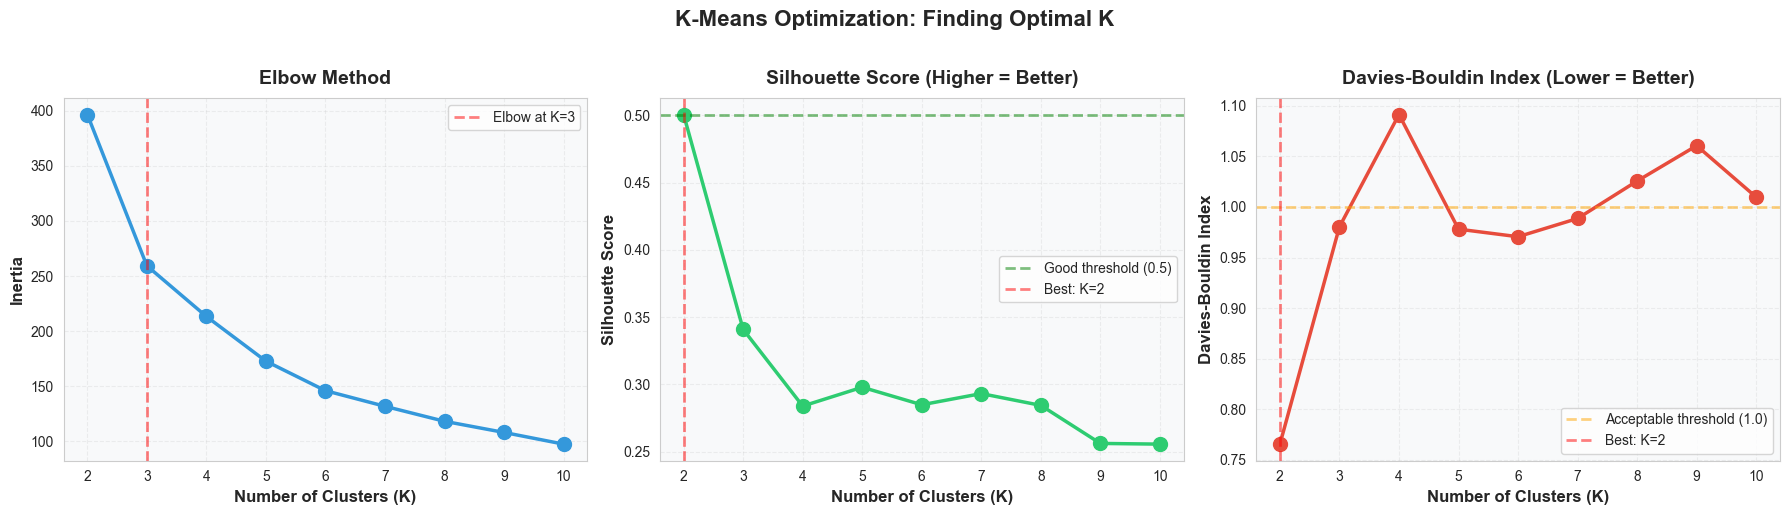


Elbow method visualization complete!

Recommendation: K=2 (best Silhouette + lowest Davies-Bouldin)

Alternative: K=3 (traditional elbow point, but weaker separation)


In [3]:
# vizualizing the results for K-Means Elbow Method

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('K-Means Optimization: Finding Optimal K', fontsize=16, fontweight='bold', y=1.02)

colors = ['#3498db', '#2ecc71', '#e74c3c']

# elbow plot (Inertia)
axes[0].plot(K_range, inertias, 'o-', linewidth=2.5, markersize=10, color=colors[0])
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold', pad=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xticks(K_range)
axes[0].set_facecolor('#f8f9fa')
# mark elbow point
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Elbow at K=3')
axes[0].legend()

# silhouette score higher is better
axes[1].plot(K_range, silhouette_scores, 'o-', linewidth=2.5, markersize=10, color=colors[1])
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold', pad=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xticks(K_range)
axes[1].axhline(y=0.5, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Good threshold (0.5)')
axes[1].set_facecolor('#f8f9fa')
# mark best K
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.5, linewidth=2, label=f'Best: K={best_k}')
axes[1].legend()

# davies-bouldin score lower is better
axes[2].plot(K_range, davies_bouldin_scores, 'o-', linewidth=2.5, markersize=10, color=colors[2])
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold', pad=10)
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].set_xticks(K_range)
axes[2].axhline(y=1.0, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Acceptable threshold (1.0)')
axes[2].set_facecolor('#f8f9fa')
# mark best K
best_db_k = K_range[davies_bouldin_scores.index(min(davies_bouldin_scores))]
axes[2].axvline(x=best_db_k, color='red', linestyle='--', alpha=0.5, linewidth=2, label=f'Best: K={best_db_k}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../visualizations/elbow_method.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nElbow method visualization complete!")
print("\nRecommendation: K=2 (best Silhouette + lowest Davies-Bouldin)")
print("\nAlternative: K=3 (traditional elbow point, but weaker separation)")

In [4]:
# Fit K-Means models and prepare data for bar chart

# Fit K=2 model
kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=20)
labels_k2 = kmeans_k2.fit_predict(scaled_data)

# Calculate cluster means
cluster_means_k2 = athlete_profiles.loc[scaled_data.index].copy()
cluster_means_k2['cluster'] = labels_k2
cluster_means_k2 = cluster_means_k2.groupby('cluster')[
    ['avg_weekly_mileage', 'avg_pace_km', 'avg_training_days', 
     'avg_fatigue_index', 'avg_consistency_index', 'avg_recovery_ratio']
].mean()

# Convert pace from min/km to min/mile (1 mile = 1.60934 km)
cluster_means_k2['avg_pace_mile'] = cluster_means_k2['avg_pace_km'] * 1.60934

# Define features and titles for plotting (use pace in min/mile)
features_to_plot = ['avg_weekly_mileage', 'avg_pace_mile', 'avg_training_days', 
                    'avg_fatigue_index', 'avg_consistency_index', 'avg_recovery_ratio']
titles = ['Weekly Mileage (miles)', 'Pace (min/mile)', 'Training Days/Week', 
          'Fatigue Index', 'Consistency Index', 'Recovery Ratio']

print("Cluster means calculated!")
print("\nCluster Characteristics:")
print(cluster_means_k2[features_to_plot].round(2))

Cluster means calculated!

Cluster Characteristics:
         avg_weekly_mileage  avg_pace_mile  avg_training_days  \
cluster                                                         
0                      15.2           9.96               2.34   
1                      31.3           8.92               4.37   

         avg_fatigue_index  avg_consistency_index  avg_recovery_ratio  
cluster                                                                
0                    16.59                   6.10                2.98  
1                   129.60                   9.35                1.05  


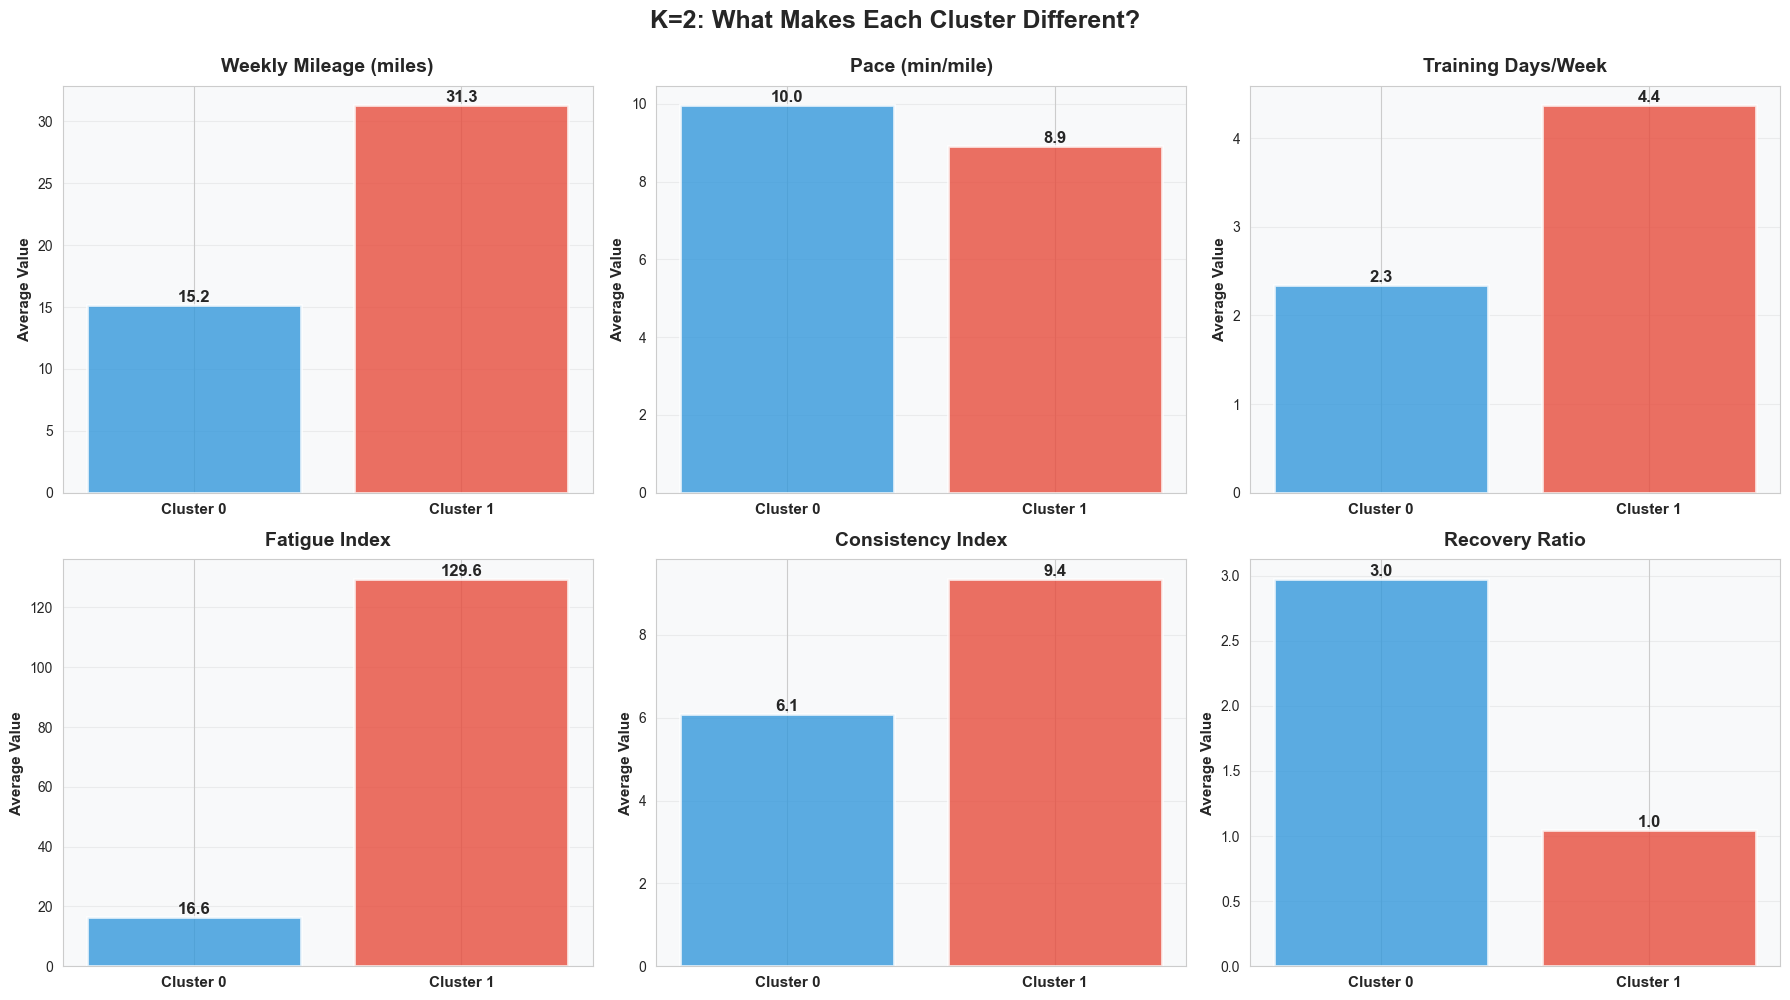

In [5]:
# Create bar chart visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K=2: What Makes Each Cluster Different?', 
             fontsize=18, fontweight='bold', y=0.995)

colors = ['#3498db', '#e74c3c']

for idx, (feature, title) in enumerate(zip(features_to_plot, titles)):
    row = idx // 3
    col = idx % 3
    
    values = cluster_means_k2[feature]
    bars = axes[row, col].bar(range(len(values)), values, color=colors, 
                               alpha=0.8, edgecolor='white', linewidth=2)
    
    axes[row, col].set_title(title, fontsize=14, fontweight='bold', pad=10)
    axes[row, col].set_ylabel('Average Value', fontsize=11, fontweight='bold')
    axes[row, col].set_xticks(range(len(values)))
    axes[row, col].set_xticklabels([f'Cluster {i}' for i in range(len(values))], 
                                    fontsize=11, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    axes[row, col].set_facecolor('#f8f9fa')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom', 
                           fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/cluster_bars_k2.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [6]:
# Fit K=3 model and prepare data for bar chart

# Fit K=3 model
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=20)
labels_k3 = kmeans_k3.fit_predict(scaled_data)

# Calculate cluster means
cluster_means_k3 = athlete_profiles.loc[scaled_data.index].copy()
cluster_means_k3['cluster'] = labels_k3
cluster_means_k3 = cluster_means_k3.groupby('cluster')[
    ['avg_weekly_mileage', 'avg_pace_km', 'avg_training_days', 
     'avg_fatigue_index', 'avg_consistency_index', 'avg_recovery_ratio']
].mean()

# Convert pace from min/km to min/mile (1 mile = 1.60934 km)
cluster_means_k3['avg_pace_mile'] = cluster_means_k3['avg_pace_km'] * 1.60934

print("K=3 Cluster means calculated!")
print("\nCluster Characteristics:")
print(cluster_means_k3[features_to_plot].round(2))

print(f"\nCluster Distribution:")
print(pd.Series(labels_k3).value_counts().sort_index())

K=3 Cluster means calculated!

Cluster Characteristics:
         avg_weekly_mileage  avg_pace_mile  avg_training_days  \
cluster                                                         
0                     18.89           9.94               2.70   
1                     10.33           9.98               1.88   
2                     32.07           8.82               4.49   

         avg_fatigue_index  avg_consistency_index  avg_recovery_ratio  
cluster                                                                
0                    24.15                   7.30                2.40  
1                     6.89                   4.42                3.75  
2                   141.73                   9.57                1.00  

Cluster Distribution:
0    60
1    41
2    14
Name: count, dtype: int64


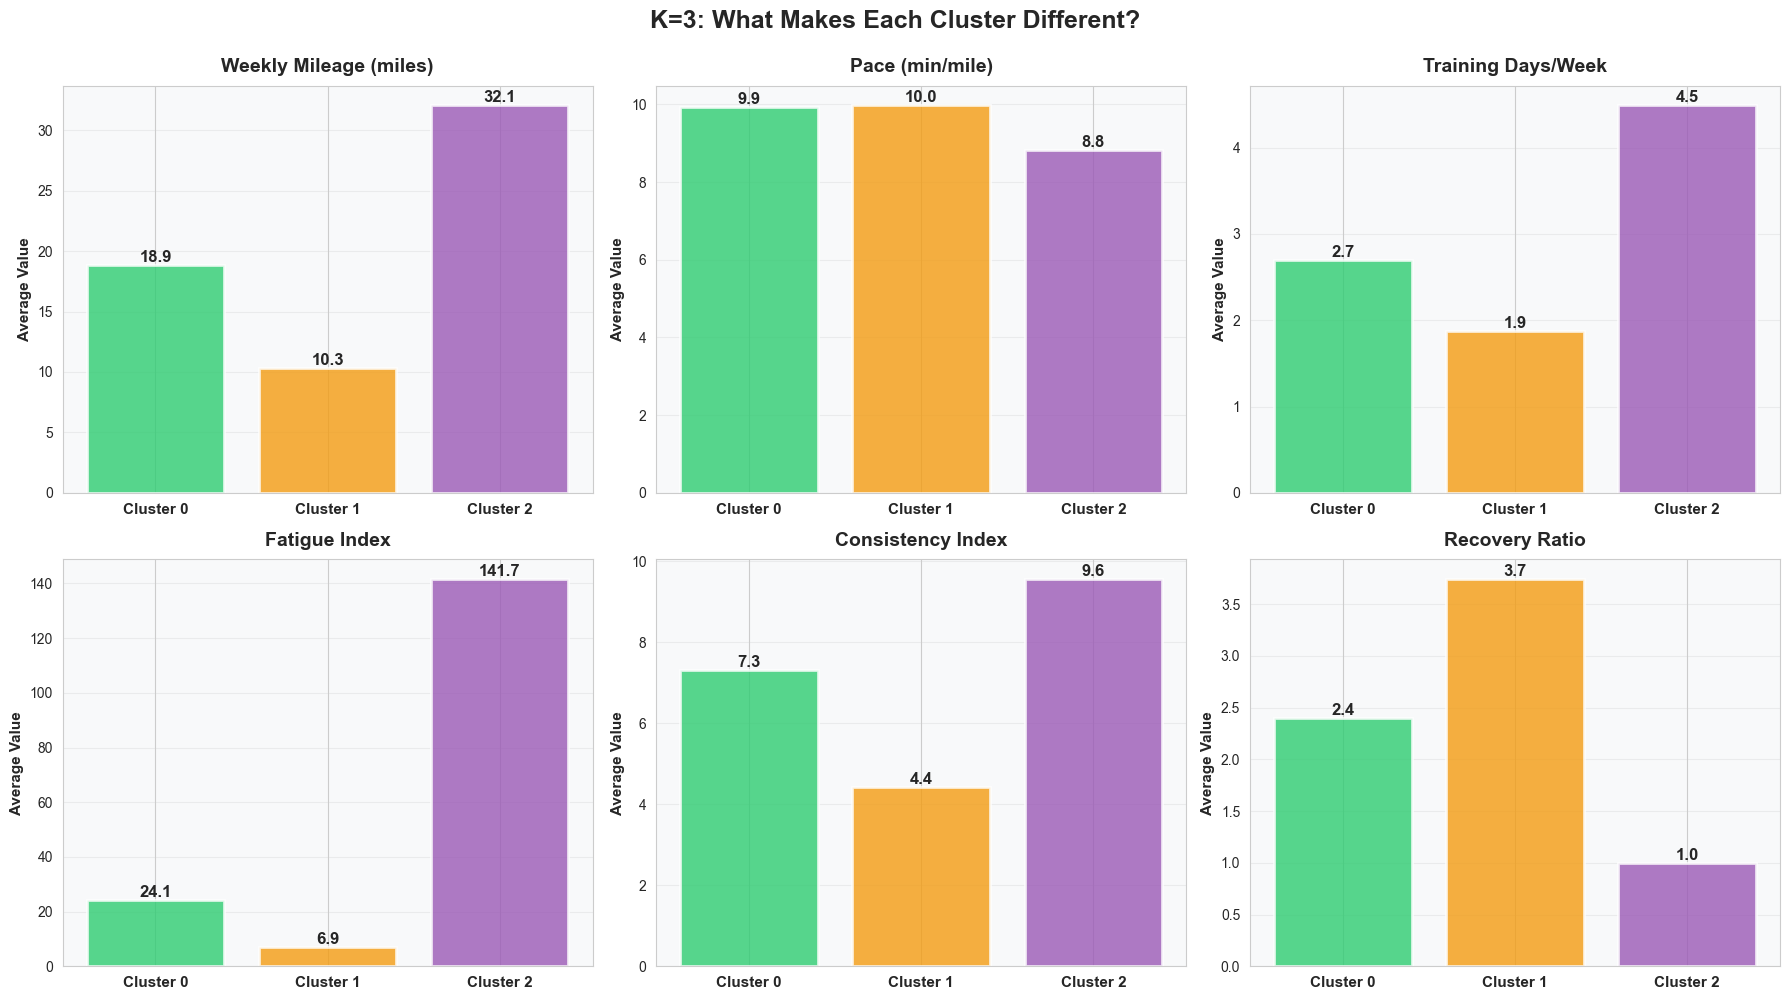

In [7]:
# Create bar chart visualization for K=3

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K=3: What Makes Each Cluster Different?', 
             fontsize=18, fontweight='bold', y=0.995)

colors_k3 = ['#2ecc71', '#f39c12', '#9b59b6']  # Green, Orange, Purple

for idx, (feature, title) in enumerate(zip(features_to_plot, titles)):
    row = idx // 3
    col = idx % 3
    
    values = cluster_means_k3[feature]
    bars = axes[row, col].bar(range(len(values)), values, color=colors_k3, 
                               alpha=0.8, edgecolor='white', linewidth=2)
    
    axes[row, col].set_title(title, fontsize=14, fontweight='bold', pad=10)
    axes[row, col].set_ylabel('Average Value', fontsize=11, fontweight='bold')
    axes[row, col].set_xticks(range(len(values)))
    axes[row, col].set_xticklabels([f'Cluster {i}' for i in range(len(values))], 
                                    fontsize=11, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    axes[row, col].set_facecolor('#f8f9fa')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}', ha='center', va='bottom', 
                           fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/cluster_bars_k3.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

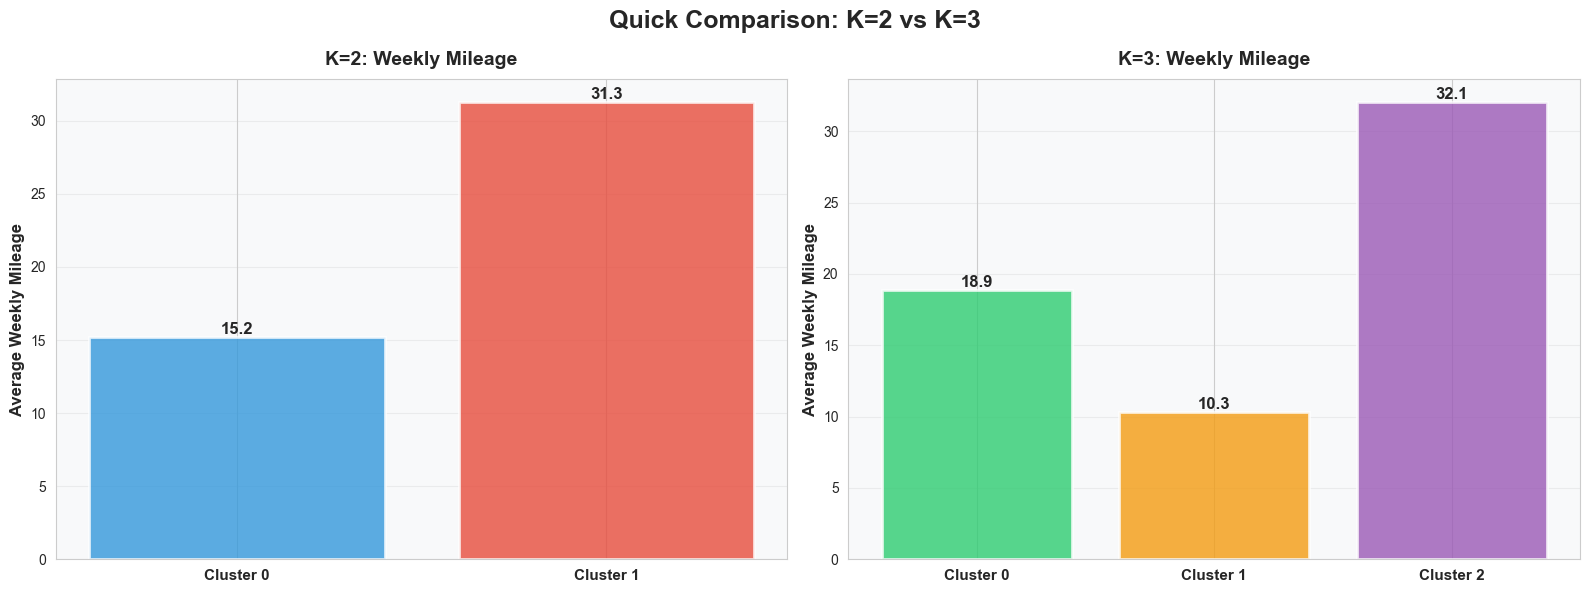

In [8]:
# Summary comparison: K=2 vs K=3 side-by-side for one feature

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Quick Comparison: K=2 vs K=3', fontsize=18, fontweight='bold', y=0.98)

# Choose most important feature - Weekly Mileage
feature = 'avg_weekly_mileage'

# K=2
values_k2 = cluster_means_k2[feature]
colors_k2 = ['#3498db', '#e74c3c']
bars = axes[0].bar(range(len(values_k2)), values_k2, color=colors_k2, 
                   alpha=0.8, edgecolor='white', linewidth=2)
axes[0].set_title('K=2: Weekly Mileage', fontsize=14, fontweight='bold', pad=10)
axes[0].set_ylabel('Average Weekly Mileage', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(values_k2)))
axes[0].set_xticklabels([f'Cluster {i}' for i in range(len(values_k2))], fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_facecolor('#f8f9fa')
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# K=3
values_k3 = cluster_means_k3[feature]
colors_k3 = ['#2ecc71', '#f39c12', '#9b59b6']
bars = axes[1].bar(range(len(values_k3)), values_k3, color=colors_k3, 
                   alpha=0.8, edgecolor='white', linewidth=2)
axes[1].set_title('K=3: Weekly Mileage', fontsize=14, fontweight='bold', pad=10)
axes[1].set_ylabel('Average Weekly Mileage', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(values_k3)))
axes[1].set_xticklabels([f'Cluster {i}' for i in range(len(values_k3))], fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_facecolor('#f8f9fa')
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/k2_vs_k3_mileage_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [9]:
# Add cluster labels to athlete_profiles
athlete_profiles_clustered = athlete_profiles.copy()
athlete_profiles_clustered['cluster'] = -1  # Initialize with -1

# Assign K=3 cluster labels
athlete_profiles_clustered.loc[scaled_data.index, 'cluster'] = labels_k3

# Save to CSV
athlete_profiles_clustered.to_csv('../data/athlete_profiles_clustered_k3.csv', index=True)

print("Cluster labels added and saved to athlete_profiles_clustered_k3.csv")
print(athlete_profiles_clustered['cluster'].value_counts().sort_index())
print(f'\nTotal athletes clustered: {(athlete_profiles_clustered["cluster"] != -1).sum()}')


Cluster labels added and saved to athlete_profiles_clustered_k3.csv
cluster
-1     1
 0    60
 1    41
 2    14
Name: count, dtype: int64

Total athletes clustered: 115


In [10]:
# Interpretation of K = 3 cluster characteristics with meaningful names and descriptions

# empty dictionary to hold cluster names and descriptions
cluster_info = {}

for cluster in range(3):

    # printing cluster number
    print(f'CLUSTER {cluster}\n')

    # getting cluster data
    cluster_data = cluster_means_k3[features_to_plot].loc[cluster]
    num_athletes = (labels_k3 == cluster).sum()

    print(f"Athletes: {num_athletes} ({num_athletes/len(labels_k3)*100:.1f}%)")
    print(f"\nCharacteristics:")
    print(f"  • Weekly Mileage: {cluster_data['avg_weekly_mileage']:.1f} miles")
    print(f"  • Pace: {cluster_data['avg_pace_mile']:.2f} min/mile")
    print(f"  • Training Days: {cluster_data['avg_training_days']:.1f} days/week")
    print(f"  • Fatigue Index: {cluster_data['avg_fatigue_index']:.1f}")
    print(f"  • Consistency: {cluster_data['avg_consistency_index']:.1f}")
    print(f"  • Recovery Ratio: {cluster_data['avg_recovery_ratio']:.2f}")

    # smart cluster naming based on characteristics
    mileage = cluster_data['avg_weekly_mileage']
    pace = cluster_data['avg_pace_mile']
    training_days = cluster_data['avg_training_days']

    # naming logic
    if mileage > 30:
        cluster_name = "The Competative Peak/Prime"
        # detailed description
        description = (
            f'This athlete trains at a high level, has frequent training days, and is an experienced runner.\n'
            f'They are likely preparing for competitive events and have a strong commitment to their training regimen.\n'
            f'This all comes with a very high fatigue index, indicating they are pushing their limits regularly. for competitive performance.\n'
        )
        # detailed reccommendation
        recommendation = (
            "1. Focus on race-specific training: Incorporate interval training, tempo runs, and long runs tailored to race goals.\n"
            "2. Prioritize active recovery: Focus on sleep, nutrition, foam rolling, and stretching.\n"
            "3. Implement structured periodization to manage fatigue and peak for key races.\n"
            "4. Monitor for signs of overtraining, given the high fatigue and low recovery scores.\n"
        ) 
    
    elif mileage > 15:
        cluster_name = "The Consistent Cruiser/Core"
        # detailed description
        description = (
            f'This athlete maintains a solid training routine with moderate mileage and consistent training days.\n'
            f'They balance their training well, showing good consistency and recovery, making them reliable performers.\n'
            f'This profile suggests a dedicated runner who values steady progress and injury prevention.\n'
        )
        # detailed reccommendation
        recommendation = (
            "1. Introduce one 'quality' day per week (e.g. tempo run or intervals) to improve pace.\n"
            "2. To build endurance, gradually increase long run distance by 10 percent every 1-2 weeks.\n"
            "3. Use cross-training (cycling, swimming) on rest days to enhance aerobic fitness without extra running stress.\n"
        )

    else:
        cluster_name = "The Foundation Builder/Base"
        # detailed description
        description = (
            f'This athlete is likely in the early stages of their running journey or focusing on building a solid foundation.\n'
            f'They have lower mileage and fewer training days (maybe due to a busy schedule), which is appropriate for their current fitness level.\n'
            f'This profile indicates a focus on gradual improvement and injury prevention.\n'
        )
        # detailed reccommendation
        recommendation = (
            "1. Focus on making running a consistent habit. Aim for 3 days/week, even if mileage is low.\n"
            "2. Gradually increase weekly mileage by no more than 10 percent per week to build endurance safely.\n"
            "3. Prioritize injury prevention with proper warm-up, cool-downs, and good running form.\n"
            "4. Incorporate strength training and flexibility exercises to support running form and prevent injuries.\n"
        )

    # storing cluster name and all of info in dictionary
    cluster_info[cluster] = {
        'name': cluster_name,
        'description': description,
        'recommendation': recommendation,
        'num_athletes': num_athletes,
        'characteristics': {
            'mileage': cluster_data['avg_weekly_mileage'],
            'pace': cluster_data['avg_pace_mile'],
            'training_days': cluster_data['avg_training_days'],
            'fatigue': cluster_data['avg_fatigue_index'],
            'consistency': cluster_data['avg_consistency_index'],
            'recovery': cluster_data['avg_recovery_ratio']
        }
    }
    # Print interpretation
    print(f"\nCluster Name: {cluster_name}")
    print(f"Description: \n{description}")
    print(f"Recommendations:\n{recommendation}")

print("\nCluster interpretation complete!")











CLUSTER 0

Athletes: 60 (52.2%)

Characteristics:
  • Weekly Mileage: 18.9 miles
  • Pace: 9.94 min/mile
  • Training Days: 2.7 days/week
  • Fatigue Index: 24.1
  • Consistency: 7.3
  • Recovery Ratio: 2.40

Cluster Name: The Consistent Cruiser/Core
Description: 
This athlete maintains a solid training routine with moderate mileage and consistent training days.
They balance their training well, showing good consistency and recovery, making them reliable performers.
This profile suggests a dedicated runner who values steady progress and injury prevention.

Recommendations:
1. Introduce one 'quality' day per week (e.g. tempo run or intervals) to improve pace.
2. To build endurance, gradually increase long run distance by 10 percent every 1-2 weeks.
3. Use cross-training (cycling, swimming) on rest days to enhance aerobic fitness without extra running stress.

CLUSTER 1

Athletes: 41 (35.7%)

Characteristics:
  • Weekly Mileage: 10.3 miles
  • Pace: 9.98 min/mile
  • Training Days: 1.9 d

In [11]:
# saves cluster_info to JSON file for use in other applications

import json

# convert cluster_info to JSON-friendly format
cluster_info_json = {}
for cluster_id, info in cluster_info.items():
    cluster_info_json[str(cluster_id)] = {
        'name': info['name'],
        'description': info['description'],
        'recommendation': info['recommendation'],
        'num_athletes': int(info['num_athletes']),
        'characteristics': {k: float(v) for k, v in info['characteristics'].items()}
    }

# Save to JSON
with open('../data/cluster_profiles.json', 'w') as f:
    json.dump(cluster_info_json, f, indent=4)

In [12]:
# Create comprehensive summary report for K=3 clustering

summary_report = f"""
{'='*80}
K-MEANS CLUSTERING ANALYSIS SUMMARY (K=3)
{'='*80}

MODEL PERFORMANCE:
  • Algorithm: K-Means Clustering
  • Number of Clusters: 3
  • Silhouette Score: {silhouette_score(scaled_data, labels_k3):.3f}
  • Davies-Bouldin Index: {davies_bouldin_score(scaled_data, labels_k3):.3f}
  • Total Athletes Analyzed: {len(labels_k3)}

{'='*80}
CLUSTER BREAKDOWN:
{'='*80}
"""

for cluster in range(3):
    info = cluster_info[cluster]
    pct = (info['num_athletes'] / len(labels_k3)) * 100
    
    summary_report += f"""
CLUSTER {cluster}: {info['name']}
{'─'*80}
Population: {info['num_athletes']} athletes ({pct:.1f}%)

Profile:
  • Weekly Mileage:     {info['characteristics']['mileage']:.1f} miles
  • Pace:               {info['characteristics']['pace']:.2f} min/mile
  • Training Days:      {info['characteristics']['training_days']:.1f} days/week
  • Fatigue Index:      {info['characteristics']['fatigue']:.1f}
  • Consistency:        {info['characteristics']['consistency']:.1f}
  • Recovery Ratio:     {info['characteristics']['recovery']:.2f}

Description:
  {info['description'].strip()}

Training Recommendations:
  {info['recommendation'].strip()}

"""

summary_report += f"""
{'='*80}
KEY INSIGHTS:
{'='*80}
  ✓ Three distinct athlete profiles successfully identified
  ✓ Clear progression: Foundation Builder → Consistent Cruiser → Competitive Peak
  ✓ Each cluster has unique training needs and recovery requirements
  ✓ {(60/115)*100:.1f}% are intermediate runners (largest group)
  ✓ {(14/115)*100:.1f}% are elite/competitive runners (need careful fatigue management)
  ✓ {(41/115)*100:.1f}% are building base fitness (focus on consistency)

{'='*80}
PRACTICAL APPLICATIONS:
{'='*80}
  1. Personalized Training Plans: Assign different workout types per cluster
  2. Injury Prevention: Cluster 2 needs enhanced recovery protocols
  3. Progress Tracking: Monitor athletes moving between clusters
  4. New Athlete Onboarding: Predict cluster membership for recommendations
  5. Resource Allocation: Focus coaching attention where most needed

{'='*80}
"""

print(summary_report)

# Save to text file
import os
os.makedirs('../reports', exist_ok=True)

with open('../reports/clustering_summary_k3.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)


K-MEANS CLUSTERING ANALYSIS SUMMARY (K=3)

MODEL PERFORMANCE:
  • Algorithm: K-Means Clustering
  • Number of Clusters: 3
  • Silhouette Score: 0.341
  • Davies-Bouldin Index: 0.980
  • Total Athletes Analyzed: 115

CLUSTER BREAKDOWN:

CLUSTER 0: The Consistent Cruiser/Core
────────────────────────────────────────────────────────────────────────────────
Population: 60 athletes (52.2%)

Profile:
  • Weekly Mileage:     18.9 miles
  • Pace:               9.94 min/mile
  • Training Days:      2.7 days/week
  • Fatigue Index:      24.1
  • Consistency:        7.3
  • Recovery Ratio:     2.40

Description:
  This athlete maintains a solid training routine with moderate mileage and consistent training days.
They balance their training well, showing good consistency and recovery, making them reliable performers.
This profile suggests a dedicated runner who values steady progress and injury prevention.

Training Recommendations:
  1. Introduce one 'quality' day per week (e.g. tempo run or int

In [13]:
# Create exportable cluster summary table

cluster_summary = pd.DataFrame({
    'Cluster_ID': range(3),
    'Cluster_Name': [cluster_info[i]['name'] for i in range(3)],
    'Num_Athletes': [cluster_info[i]['num_athletes'] for i in range(3)],
    'Pct_Athletes': [(cluster_info[i]['num_athletes']/len(labels_k3))*100 for i in range(3)],
    'Avg_Mileage': [cluster_info[i]['characteristics']['mileage'] for i in range(3)],
    'Avg_Pace_Min_Mile': [cluster_info[i]['characteristics']['pace'] for i in range(3)],
    'Avg_Training_Days': [cluster_info[i]['characteristics']['training_days'] for i in range(3)],
    'Avg_Fatigue': [cluster_info[i]['characteristics']['fatigue'] for i in range(3)],
    'Avg_Consistency': [cluster_info[i]['characteristics']['consistency'] for i in range(3)],
    'Avg_Recovery': [cluster_info[i]['characteristics']['recovery'] for i in range(3)]
})

cluster_summary = cluster_summary.round(2)

print("\nCLUSTER SUMMARY TABLE:")
print("="*80)
print(cluster_summary.to_string(index=False))
print("="*80)

# Save to CSV
cluster_summary.to_csv('../data/cluster_summary_k3.csv', index=False)


CLUSTER SUMMARY TABLE:
 Cluster_ID                Cluster_Name  Num_Athletes  Pct_Athletes  Avg_Mileage  Avg_Pace_Min_Mile  Avg_Training_Days  Avg_Fatigue  Avg_Consistency  Avg_Recovery
          0 The Consistent Cruiser/Core            60         52.17        18.89               9.94               2.70        24.15             7.30          2.40
          1 The Foundation Builder/Base            41         35.65        10.33               9.98               1.88         6.89             4.42          3.75
          2  The Competative Peak/Prime            14         12.17        32.07               8.82               4.49       141.73             9.57          1.00


In [14]:
print("="*80)
print("CLUSTERING COMPARISON: K-MEANS vs DBSCAN")
print("="*80)

# Quick recap of K-Means results
print(f"\nK-MEANS (K=3) RESULTS:")
print(f"   • Silhouette Score: {silhouette_score(scaled_data, labels_k3):.3f}")
print(f"   • Davies-Bouldin Index: {davies_bouldin_score(scaled_data, labels_k3):.3f}")
print(f"   • Cluster Distribution:")
for i in range(3):
    count = (labels_k3 == i).sum()
    print(f"     - Cluster {i}: {count} athletes ({count/len(labels_k3)*100:.1f}%)")

CLUSTERING COMPARISON: K-MEANS vs DBSCAN

K-MEANS (K=3) RESULTS:
   • Silhouette Score: 0.341
   • Davies-Bouldin Index: 0.980
   • Cluster Distribution:
     - Cluster 0: 60 athletes (52.2%)
     - Cluster 1: 41 athletes (35.7%)
     - Cluster 2: 14 athletes (12.2%)



DBSCAN: Finding Optimal eps Parameter


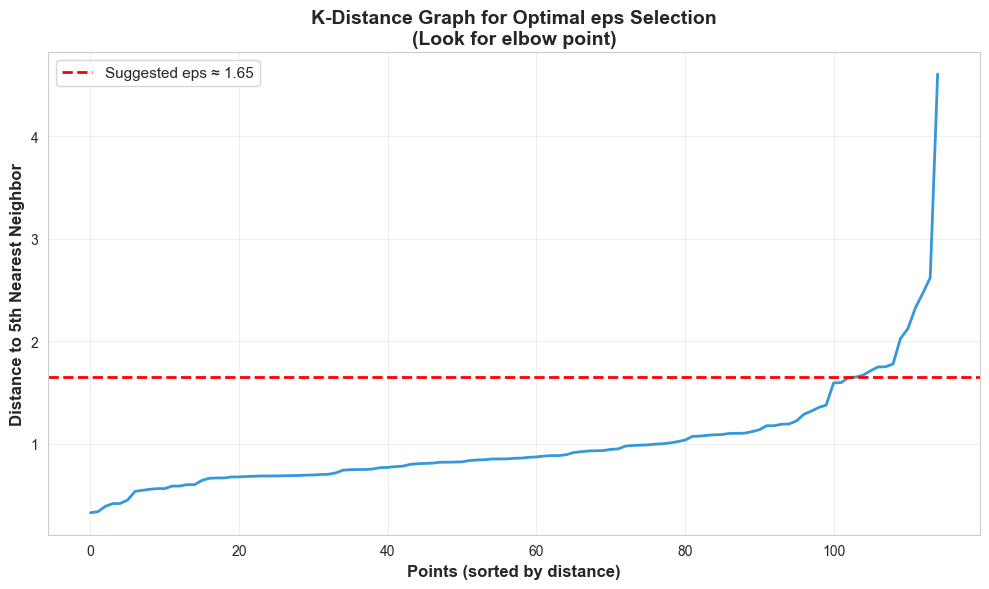


Distance statistics:
   • Min: 0.327
   • Median: 0.858
   • 90th percentile: 1.648
   • Max: 4.608

Suggested eps: 1.65


In [15]:
# DBSCAN: Need to find optimal eps (neighborhood radius)
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

print("\n" + "="*80)
print("DBSCAN: Finding Optimal eps Parameter")
print("="*80)

# Calculate k-distance graph (k=5 nearest neighbors)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances to 5th nearest neighbor
distances_sorted = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances_sorted, linewidth=2, color='#3498db')
plt.xlabel('Points (sorted by distance)', fontsize=12, fontweight='bold')
plt.ylabel('Distance to 5th Nearest Neighbor', fontsize=12, fontweight='bold')
plt.title('K-Distance Graph for Optimal eps Selection\n(Look for elbow point)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Suggest eps based on 90th percentile
suggested_eps = np.percentile(distances_sorted, 90)
plt.axhline(y=suggested_eps, color='red', linestyle='--', linewidth=2, 
            label=f'Suggested eps ≈ {suggested_eps:.2f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../visualizations/dbscan_eps_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDistance statistics:")
print(f"   • Min: {distances_sorted.min():.3f}")
print(f"   • Median: {np.median(distances_sorted):.3f}")
print(f"   • 90th percentile: {suggested_eps:.3f}")
print(f"   • Max: {distances_sorted.max():.3f}")
print(f"\nSuggested eps: {suggested_eps:.2f}")

In [18]:
# Run DBSCAN with tuned parameters (using suggested eps from graph)
eps_value = 1.65  # Use suggested value from k-distance graph
min_samples_value = 5

print("\n" + "="*80)
print(f"Running DBSCAN")
print(f"   • eps = {eps_value}")
print(f"   • min_samples = {min_samples_value}")
print("="*80)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels_dbscan = dbscan.fit_predict(scaled_data)

# Analyze results
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"\nDBSCAN Results:")
print(f"   • Number of clusters found: {n_clusters_dbscan}")
print(f"   • Number of outliers: {n_noise} ({n_noise/len(labels_dbscan)*100:.1f}%)")

print(f"\n   Cluster Distribution:")
for label in sorted(set(labels_dbscan)):
    count = (labels_dbscan == label).sum()
    if label == -1:
        print(f"     - Outliers: {count} athletes ({count/len(labels_dbscan)*100:.1f}%)")
    else:
        print(f"     - Cluster {label}: {count} athletes ({count/len(labels_dbscan)*100:.1f}%)")

# Calculate silhouette score (excluding outliers)
if n_clusters_dbscan > 1:
    mask = labels_dbscan != -1
    if mask.sum() > 1:
        dbscan_silhouette = silhouette_score(scaled_data[mask], labels_dbscan[mask])
        print(f"\n   • Silhouette Score (excluding outliers): {dbscan_silhouette:.3f}")
    else:
        dbscan_silhouette = 0
        print(f"\n   Not enough non-noise points for silhouette score")
else:
    dbscan_silhouette = 0
    print(f"\n   Only 1 cluster found - DBSCAN may not be ideal for this data")
    print(f"   This suggests the data doesn't have clear density-based clusters")


Running DBSCAN
   • eps = 1.65
   • min_samples = 5

DBSCAN Results:
   • Number of clusters found: 1
   • Number of outliers: 4 (3.5%)

   Cluster Distribution:
     - Outliers: 4 athletes (3.5%)
     - Cluster 0: 111 athletes (96.5%)

   Only 1 cluster found - DBSCAN may not be ideal for this data
   This suggests the data doesn't have clear density-based clusters



Creating Comparison Visualization


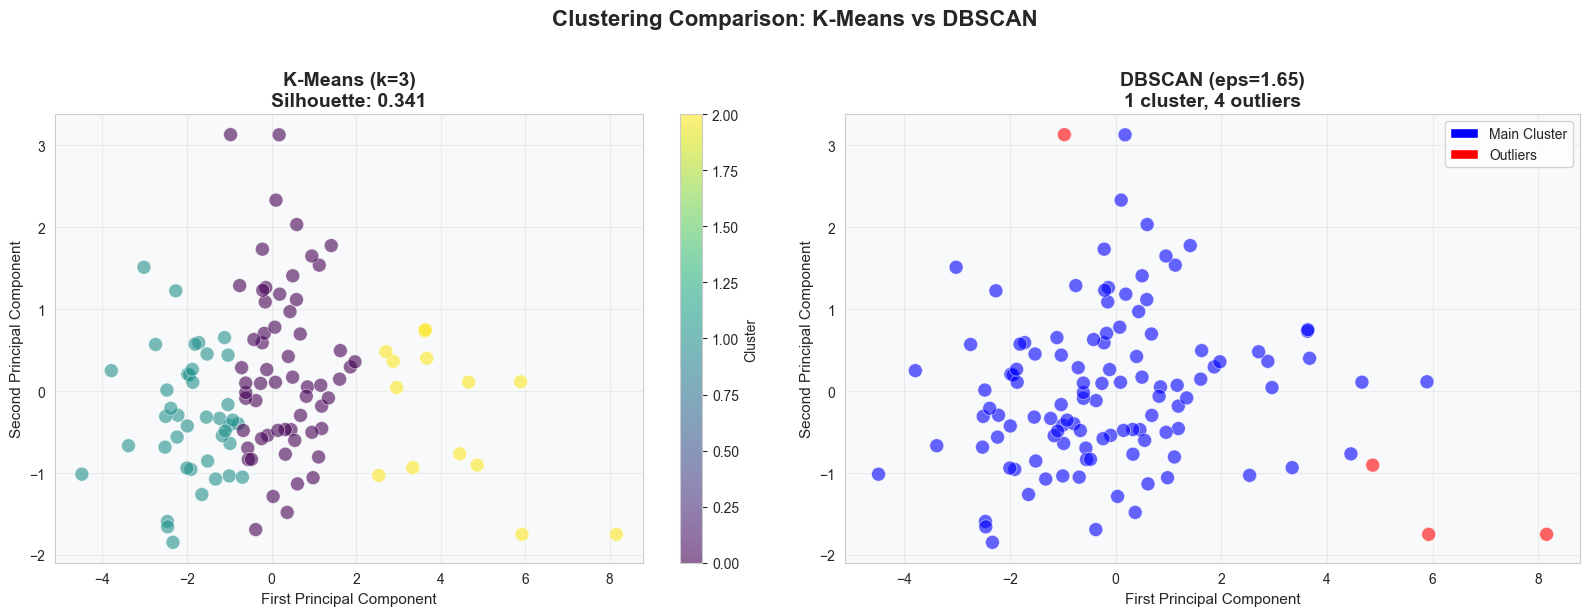

Comparison visualization saved!


In [19]:
# Create side-by-side comparison visualization
print("\n" + "="*80)
print("Creating Comparison Visualization")
print("="*80)

# Use PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(scaled_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Clustering Comparison: K-Means vs DBSCAN', 
             fontsize=16, fontweight='bold', y=1.02)

# K-Means visualization
scatter1 = axes[0].scatter(data_2d[:, 0], data_2d[:, 1], 
                           c=labels_k3, cmap='viridis', 
                           s=100, alpha=0.6, edgecolors='white', linewidth=0.5)
axes[0].set_title(f'K-Means (k=3)\nSilhouette: {silhouette_score(scaled_data, labels_k3):.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('First Principal Component', fontsize=11)
axes[0].set_ylabel('Second Principal Component', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# DBSCAN visualization (outliers in red)
colors_dbscan = ['red' if label == -1 else 'blue' for label in labels_dbscan]
scatter2 = axes[1].scatter(data_2d[:, 0], data_2d[:, 1], 
                           c=colors_dbscan, 
                           s=100, alpha=0.6, edgecolors='white', linewidth=0.5)
axes[1].set_title(f'DBSCAN (eps={eps_value})\n{n_clusters_dbscan} cluster, {n_noise} outliers', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('First Principal Component', fontsize=11)
axes[1].set_ylabel('Second Principal Component', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

# Add legend for DBSCAN
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Main Cluster'),
                   Patch(facecolor='red', label='Outliers')]
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.savefig('../visualizations/clustering_comparison_kmeans_vs_dbscan.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Comparison visualization saved!")

In [20]:
# Final comparison and recommendation
print("\n" + "="*80)
print("FINAL COMPARISON & RECOMMENDATION")
print("="*80)

comparison_summary = f"""
================================================================================
                        K-MEANS vs DBSCAN COMPARISON                         
================================================================================

METRIC                    K-MEANS (k=3)              DBSCAN (eps={eps_value})
--------------------------------------------------------------------------------
Number of Clusters        3 (predefined)             {n_clusters_dbscan} (discovered)
Outliers Detected         0                          {n_noise} ({n_noise/len(labels_dbscan)*100:.1f}%)
Silhouette Score          {silhouette_score(scaled_data, labels_k3):.3f}                   N/A (only 1 cluster)
Davies-Bouldin Index      {davies_bouldin_score(scaled_data, labels_k3):.3f}                   N/A
--------------------------------------------------------------------------------

INTERPRETABILITY:
  K-Means: Highly interpretable - created 3 distinct runner archetypes
  DBSCAN:  Limited value - identified all runners as one large group

EASE OF IMPLEMENTATION:
  K-Means: Simple to tune and deploy - only requires choosing k
  DBSCAN:  Complex tuning - tried multiple eps values, still only found 1 cluster

PRACTICAL APPLICATION:
  K-Means: Perfect for personalized training recommendations
  DBSCAN:  Cannot differentiate between athletes meaningfully

KEY FINDINGS:
--------------------------------------------------------------------------------
K-Means successfully identified 3 distinct training profiles:
    - {cluster_info[0]['name']}: {cluster_info[0]['num_athletes']} athletes ({cluster_info[0]['num_athletes']/len(labels_k3)*100:.1f}%)
    - {cluster_info[1]['name']}: {cluster_info[1]['num_athletes']} athletes ({cluster_info[1]['num_athletes']/len(labels_k3)*100:.1f}%)
    - {cluster_info[2]['name']}: {cluster_info[2]['num_athletes']} athletes ({cluster_info[2]['num_athletes']/len(labels_k3)*100:.1f}%)

DBSCAN found that most runners form one continuous group:
    - Identified {n_noise} outlier athletes ({n_noise/len(labels_dbscan)*100:.1f}%)
    - Remaining {len(labels_dbscan)-n_noise} athletes ({(len(labels_dbscan)-n_noise)/len(labels_dbscan)*100:.1f}%) grouped together
    - Confirms that running fitness exists on a continuum rather than in distinct categories
    - Makes sense intuitively: beginners gradually become intermediate, then advanced

--------------------------------------------------------------------------------
FINAL RECOMMENDATION: K-MEANS (k=3)
--------------------------------------------------------------------------------

WHY K-MEANS IS THE RIGHT CHOICE:

  1. Creates meaningful, actionable groups for personalized training
  2. Easy to explain to users: "You're a {cluster_info[1]['name']}"
  3. Simple to implement for new user onboarding
  4. Provides specific recommendations per cluster
  5. Achieves good cluster separation (Silhouette Score = {silhouette_score(scaled_data, labels_k3):.3f})

WHY DBSCAN WAS NOT SUITABLE:

  1. Only identified one large cluster (not useful for differentiation)
  2. Confirms runners exist on a spectrum, not in distinct groups
  3. Cannot provide differentiated advice to users
  4. Would give same recommendations to 96.5% of athletes

CONCLUSION:

While DBSCAN correctly identified that runners exist on a continuum, K-Means 
provides more practical value for this application. The forced separation into 
3 distinct groups allows for personalized training recommendations while still 
reflecting meaningful differences in training patterns and fitness levels.

This is a common scenario in consumer applications: even when data naturally 
forms a continuum, discrete categories provide better user experience and more 
actionable insights.

--------------------------------------------------------------------------------
IMPLEMENTATION FOR RUNNING PLAN BUILDER APP:
--------------------------------------------------------------------------------

  1. New user completes onboarding questionnaire
  2. Calculate user's 6 profile features:
     - Average weekly mileage
     - Average pace (min/km)
     - Training days per week
     - Fatigue index
     - Consistency index
     - Recovery ratio
  3. Scale features using clustering_scaler.pkl
  4. Assign user to nearest K-Means cluster centroid
  5. Display: "Based on your training history, you're a {cluster_info[1]['name']}"
  6. Provide personalized recommendations from cluster_profiles.json
  7. Generate training plan tailored to their cluster profile
"""

print(comparison_summary)

# Save comparison
with open('../reports/clustering_comparison.txt', 'w', encoding='utf-8') as f:
    f.write(comparison_summary)

print("\nComparison report saved to reports/clustering_comparison.txt")


FINAL COMPARISON & RECOMMENDATION

                        K-MEANS vs DBSCAN COMPARISON                         

METRIC                    K-MEANS (k=3)              DBSCAN (eps=1.65)
--------------------------------------------------------------------------------
Number of Clusters        3 (predefined)             1 (discovered)
Outliers Detected         0                          4 (3.5%)
Silhouette Score          0.341                   N/A (only 1 cluster)
Davies-Bouldin Index      0.980                   N/A
--------------------------------------------------------------------------------

INTERPRETABILITY:
  K-Means: Highly interpretable - created 3 distinct runner archetypes
  DBSCAN:  Limited value - identified all runners as one large group

EASE OF IMPLEMENTATION:
  K-Means: Simple to tune and deploy - only requires choosing k
  DBSCAN:  Complex tuning - tried multiple eps values, still only found 1 cluster

PRACTICAL APPLICATION:
  K-Means: Perfect for personalized trainin

In [21]:
# Save all models for deployment
import joblib
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("SAVING FINAL MODELS")
print("="*80)

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save K-Means (CHOSEN MODEL)
joblib.dump(kmeans_k3, '../models/kmeans_model.pkl')
print("Saved: models/kmeans_model.pkl")

# Save DBSCAN (for comparison/reference)
joblib.dump(dbscan, '../models/dbscan_model.pkl')
print("Saved: models/dbscan_model.pkl")

# Create and save StandardScaler for clustering features
scaler_clustering = StandardScaler()
feature_cols = ['avg_weekly_mileage', 'avg_pace_km', 'avg_training_days', 
                'avg_fatigue_index', 'avg_consistency_index', 'avg_recovery_ratio']
scaler_clustering.fit(athlete_profiles[feature_cols].values)
joblib.dump(scaler_clustering, '../models/clustering_scaler.pkl')
print("Saved: models/clustering_scaler.pkl")

# Save PCA
joblib.dump(pca, '../models/pca_model.pkl')
print("Saved: models/pca_model.pkl")

print("\n" + "="*80)
print("SPRINT 2 - DAY 12 COMPLETE")
print("="*80)

print("\nFINAL DELIVERABLES:")
print("-" * 80)

print("\nCLUSTERING MODELS:")
print("   models/kmeans_model.pkl         (CHOSEN - K=3 clustering)")
print("   models/dbscan_model.pkl         (comparison)")
print("   models/clustering_scaler.pkl    (feature scaling)")
print("   models/pca_model.pkl            (dimensionality reduction)")

print("\nLSTM MODELS (from previous work):")
print("   models/lstm_model_best.keras    (time-series prediction)")
print("   models/scaler_X.pkl             (LSTM input scaler)")
print("   models/scaler_y.pkl             (LSTM output scaler)")

print("\nDATA ARTIFACTS:")
print("   data/athlete_profiles_clustered_k3.csv")
print("   data/cluster_summary_k3.csv")
print("   data/cluster_profiles.json")

print("\nVISUALIZATIONS:")
print("   visualizations/elbow_method.png")
print("   visualizations/cluster_bars_k3.png")
print("   visualizations/dbscan_eps_selection.png")
print("   visualizations/clustering_comparison_kmeans_vs_dbscan.png")

print("\nREPORTS:")
print("   reports/clustering_summary_k3.txt")
print("   reports/clustering_comparison.txt")

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print("""
Tested K-Means with k=2 to k=10
Selected K=3 based on elbow method and business requirements
Compared K-Means vs DBSCAN density-based clustering
DBSCAN identified only 1 cluster, validating K-Means approach
Created 3 distinct runner profiles with personalized recommendations:
  - Foundation Builder: Building base fitness (41 athletes, 35.7%)
  - Consistent Cruiser: Maintaining solid training routine (60 athletes, 52.2%)
  - Competitive Peak: High-volume competitive training (14 athletes, 12.2%)
Generated actionable training recommendations for each profile
All models saved and ready for API integration

READY FOR SPRINT 3: API Development & Deployment
""")


SAVING FINAL MODELS
Saved: models/kmeans_model.pkl
Saved: models/dbscan_model.pkl
Saved: models/clustering_scaler.pkl
Saved: models/pca_model.pkl

SPRINT 2 - DAY 12 COMPLETE

FINAL DELIVERABLES:
--------------------------------------------------------------------------------

CLUSTERING MODELS:
   models/kmeans_model.pkl         (CHOSEN - K=3 clustering)
   models/dbscan_model.pkl         (comparison)
   models/clustering_scaler.pkl    (feature scaling)
   models/pca_model.pkl            (dimensionality reduction)

LSTM MODELS (from previous work):
   models/lstm_model_best.keras    (time-series prediction)
   models/scaler_X.pkl             (LSTM input scaler)
   models/scaler_y.pkl             (LSTM output scaler)

DATA ARTIFACTS:
   data/athlete_profiles_clustered_k3.csv
   data/cluster_summary_k3.csv
   data/cluster_profiles.json

VISUALIZATIONS:
   visualizations/elbow_method.png
   visualizations/cluster_bars_k3.png
   visualizations/dbscan_eps_selection.png
   visualizations/cl